## Load dependencies

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd /content/drive/MyDrive/Training/UNet

In [46]:
import os

import torch 
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from unet.Unet import *

In [47]:
device = 'mps'

In [48]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #  576 choosen because, height and width would be even after 4 maxpooling
    transforms.Resize([576, 576]),
])

## Dataset preparation

In [49]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms):

        self.imagefiles = os.listdir(imagePaths)
        self.maskfiles = os.listdir(maskPaths)
        
        if  '.DS_Store' in self.imagefiles:
            self.imagefiles.remove( '.DS_Store')
        if  '.DS_Store' in self.maskfiles:
            self.maskfiles.remove( '.DS_Store')
            
        self.imagefiles.sort()
        self.maskfiles.sort()
    
        for i in range(len(self.imagefiles)):
            self.imagefiles[i] = os.path.join(imagePaths,self.imagefiles[i])
            self.maskfiles[i] = os.path.join(maskPaths, self.maskfiles[i])
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagefiles)
    
    def __getitem__(self, idx):
        imagePath = self.imagefiles[idx]
        maskPath = self.maskfiles[idx]
        
        image =Image.open(imagePath)
        #m = Image.open(maskPath).convert('A')
        mask =Image.open(maskPath)
        mask = ImageOps.grayscale(mask)
        
        image = self.transforms(image)
        mask = self.transforms(mask)
        
        return (image, mask)

In [50]:
dataset = SegmentationDataset('data/imgs', 'data/masks', train_transform)

## Prepare Dataloader

In [51]:
torch.manual_seed(1)

total = len(dataset)
train_size = 0.75

train_total = int(train_size * total)
test_total = int((1-train_size )* total)

valid_total =  int((1-train_size) * train_total)
actual_train_total = int(train_size * train_total)


print(f'Train size: {actual_train_total} \nValidation Size: {valid_total} \nTest Size: {test_total}') 

Train size: 2862 
Validation Size: 954 
Test Size: 1272


In [52]:
randomised_idx = torch.randperm(total)

data_train = Subset(dataset, randomised_idx[:train_total])
data_test = Subset(dataset, randomised_idx[train_total: ])

data_train = Subset(dataset,randomised_idx[:actual_train_total])
data_valid = Subset(dataset, randomised_idx[actual_train_total: actual_train_total + valid_total])

In [53]:
len(data_train), len(data_valid), len(data_test)

(2862, 954, 1272)

In [54]:
data = DataLoader(data_train, batch_size=1, shuffle=True)
data_vl = DataLoader(data_valid, batch_size=1, shuffle=True)

In [55]:
next(iter(data))[0].shape

torch.Size([1, 3, 576, 576])

## Visualise data

In [56]:
import numpy as np

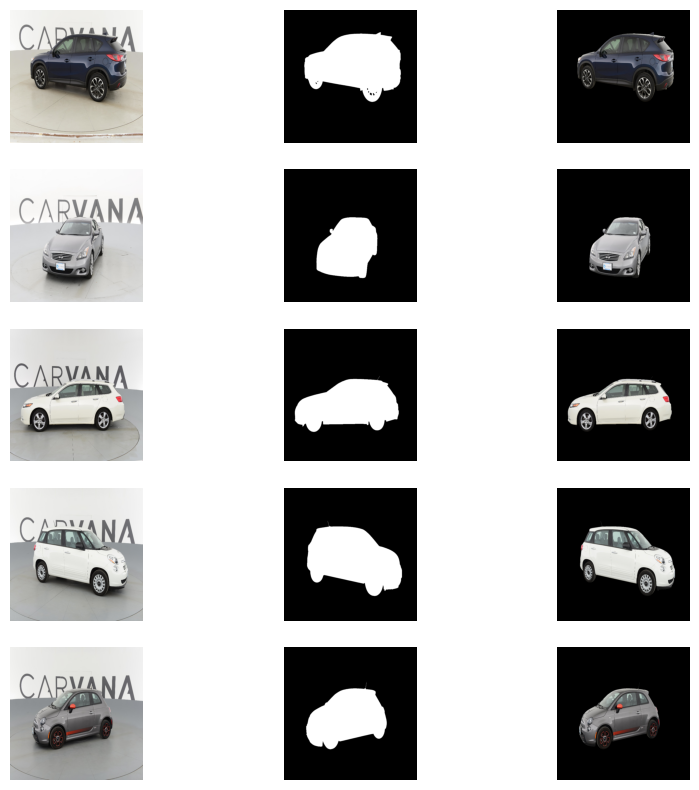

In [57]:
viz_data = DataLoader(data_train, 5, shuffle=False)

image_batch, mask_batch = next(iter(viz_data))
plt.figure(figsize=(10,10))

for i in range(1,16, 3):
    image_proper = (image_batch[i//3].permute(1,2,0))
    mask_proper = (mask_batch[i//3].permute(1,2,0))
    
    plt.subplot(5,3,i)
    plt.axis('off')
    plt.imshow(image_proper)
    
    plt.subplot(5,3,i+1)
    plt.axis('off')

    plt.imshow(mask_proper.squeeze(2), cmap='gray')
    
    plt.subplot(5,3,i+2)
    mask = mask_proper.permute(2,0,1)
    mask = transforms.ToPILImage()(mask)
    mask = transforms.Grayscale(num_output_channels=3)(mask)
    image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

    image_masked = image_masked.numpy().transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(np.uint8(image_masked))
    

plt.show()

## Training step

In [183]:
model = UNet(3, 1)
model

UNet(
  (initial): InsideBlockConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): ContractionBlock(
    (contraction): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): InsideBlockConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm

In [184]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.99)
loss_fn = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()


In [186]:
from torchmetrics import JaccardIndex # i.e IoU

In [190]:
def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_jaccard = [0] * epoch
    validation_loss = [0] * epoch
    validation_jaccard = [0] * epoch
    for i in range(epoch):
        for x_batch, y_batch in data:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += (loss.item() * x_batch.size(0))
            
            y_batch = y_batch.to(torch.int)
            pred = torch.round(pred)
            
            jaccard = JaccardIndex(task="binary", num_classes=1)
            train_jaccard[i] += jaccard(pred.cpu(), y_batch.cpu())
            # print("-----------------------------------------------------",calculate_iou(pred.cpu().to(torch.int8), y_batch.cpu().to(torch.int8)))
            # is_crt = ((pred>=0.5) == y_batch).sum().cpu()
            # train_accuracy[i] += is_crt.float()
        train_loss[i] /= len(data.dataset)
        train_jaccard[i] /= len(data.dataset)
        print('Train over, validation begins...')
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                validation_loss[i] += (loss.item() * x_batch.size(0))
                
                y_batch = y_batch.to(torch.int) 
                pred = torch.round(pred)

                jaccard = JaccardIndex(task="binary", num_classes=1)
                validation_jaccard[i] += jaccard(pred.cpu(), y_batch.cpu())
                
            validation_loss[i] /= len(data_vl.dataset)
            validation_jaccard[i] /= len(data_vl.dataset)
        print(f'Epoch {i+1} \nloss: {train_loss[i]:.4f} val_loss:{validation_loss[i]:.4f}\njaccard: {train_jaccard[i]:.4f} val_jaccard:{validation_jaccard[i]:.4f}')
        print()
    return train_loss, train_jaccard, validation_loss, validation_jaccard

In [191]:
data_sub_train = Subset(data_train, np.arange(1000))

In [192]:
datasub = DataLoader(data_sub_train, batch_size=1, shuffle=True)

In [193]:
%%time
model = model.to(device)
epoch = 4
train_loss, train_iou, validation_loss, validation_iou = train(model, epoch, datasub, data_vl)

Train over, validation begins...
Epoch 1 
loss: 0.0900 val_loss:0.0388
jaccard: 0.8405 val_jaccard:0.9241

Train over, validation begins...
Epoch 2 
loss: 0.0327 val_loss:0.0228
jaccard: 0.9335 val_jaccard:0.9500

Train over, validation begins...
Epoch 3 
loss: 0.0198 val_loss:0.0222
jaccard: 0.9543 val_jaccard:0.9550

Train over, validation begins...
Epoch 4 
loss: 0.0173 val_loss:0.0184
jaccard: 0.9583 val_jaccard:0.9594

CPU times: user 13min 58s, sys: 8min 20s, total: 22min 19s
Wall time: 1h 23min 50s


In [19]:
ls

LICENSE             Segmentation.ipynb  download.sh*        unet/
README.md           data/               images/


In [127]:
len(data_test)

1272

In [194]:
image , mask = data_test[120][0], data_test[120][1]

image = image.unsqueeze(0)
image = image.to(device)

pred = model(image).squeeze(0).cpu().detach()
image = image.squeeze(0).cpu()
print(pred)
pred = torch.round(pred) ## Must needed for proper segmented display
print(pred)

tensor([[[ -6.4329,  -6.4695,  -6.9516,  ...,  -7.0629,  -6.8542,  -6.8517],
         [ -6.2746,  -7.0643,  -7.9846,  ...,  -8.2242,  -7.7596,  -6.7081],
         [ -6.5997,  -7.8438,  -8.6692,  ...,  -9.2444,  -8.6582,  -7.0901],
         ...,
         [ -6.6338,  -7.5934,  -8.9373,  ..., -10.4632,  -9.6631,  -7.6727],
         [ -6.3003,  -7.2312,  -8.4898,  ..., -10.1194,  -9.4214,  -7.5093],
         [ -6.2480,  -6.2576,  -6.8752,  ...,  -7.8617,  -7.3412,  -6.3625]]])
tensor([[[ -6.,  -6.,  -7.,  ...,  -7.,  -7.,  -7.],
         [ -6.,  -7.,  -8.,  ...,  -8.,  -8.,  -7.],
         [ -7.,  -8.,  -9.,  ...,  -9.,  -9.,  -7.],
         ...,
         [ -7.,  -8.,  -9.,  ..., -10., -10.,  -8.],
         [ -6.,  -7.,  -8.,  ..., -10.,  -9.,  -8.],
         [ -6.,  -6.,  -7.,  ...,  -8.,  -7.,  -6.]]])


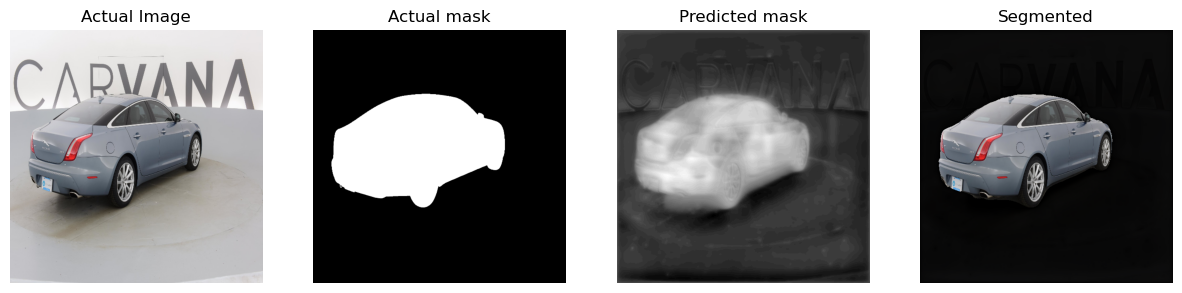

In [195]:
image_proper = (image.permute(1,2,0))
mask_proper = (mask.permute(1,2,0))
predicted_mask_proper = (pred.permute(1,2,0))

plt.figure(figsize=(15,35))
plt.tight_layout()
plt.subplot(5,4,i)
plt.title('Actual Image')
plt.axis('off')
plt.imshow(image_proper)

plt.subplot(5,4,i+1)
plt.title('Actual mask')
plt.axis('off')
plt.imshow(mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+2)
plt.title('Predicted mask')
plt.axis('off')
plt.imshow(predicted_mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+3)
plt.title('Segmented')
mask = predicted_mask_proper.permute(2,0,1)
mask = transforms.ToPILImage()(mask)
mask = transforms.Grayscale(num_output_channels=3)(mask)
image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

image_masked = image_masked.numpy().transpose(1, 2, 0)
plt.axis('off')
plt.imshow(np.uint8(image_masked))

**Note**
- In just 1 epoch it outputs reasonably good mask. I am sticking to 4 epoch and that too with not the complete train data. I use only 1000 training data size because of limited computing resource locally.
    - My free colab plan is exausted 🙃
- Will have to improve the training strategies, possibly divide the input image into large tiles and finally generate the output mask.S